### YOLO & Mediapipe & LSTM/GRU를 사용한 모델
* 원본: https://github.com/seonydg/LSTM-for-Anomaly-Detection

In [63]:
import numpy as np
import os
import json
import cv2
import glob
import sklearn
import time

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix

from scipy.interpolate import interp1d
from scipy.spatial import distance

from tqdm import tqdm
from itertools import product, chain

from show_graph_until_epoch import * # show_graph_until_epoch.py

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
# 프레임 및 bbox 누락 확인용
null_frame = 0
null_bbox = 0
for i, file in enumerate(glob.glob(f'{train_root}\\*')):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        if len(data['pose_data']) < 90:
            null_frame += 1
        for frame in data['pose_data']:
            if 'bbox' in list(data['pose_data'][frame].keys()):
                print(list(data['pose_data'][frame].keys()))
                null_bbox += 1
print(null_frame)
print(null_bbox)
# 프레임 누락 존재 확인
# 존재하는 프레임에는 bbox 누락이 없음을 확인

NameError: name 'train_root' is not defined

In [101]:
# 상수값 설정
LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]
DR = 'E'
FRAME_INTERVAL = 6
VID_LEN = 600
FRAMES = list(range(0, VID_LEN, FRAME_INTERVAL))
CLASS_LIST = ['Normal', 'Fall', 'Danger']
BATCH_SIZE = 32
VID_RESOLUTION = (3840, 2160)

# 모델에 넣을 값 설정(기본적으로 pose_xy 포함)
MODEL_INPUT_DATA_TYPE = {
    'bbox_xyxy': False,
    'bbox_ratio': True,
    'bbox_class': True,
    'head_torso_speed': True,
}
MODEL_TYPE = 'normal'

In [102]:
# 누락된 프레임을 보간하여 채워 넣음
# 이전 코드와의 호환을 위해 기존의 json 파일 형식으로 결과값 반환
def fill_missing_data(data):
    frame_exist_list = [int(x.split('_')[-1]) for x in data['pose_data']]
    key_list = list(map(lambda x: CLASS_LIST.index(x['class']), data['pose_data'].values()))
    pose_list = list(map(lambda x: list(chain(*[list(v.values()) for k, v in x.items() if 'landmark' in k])), data['pose_data'].values()))
    bbox_list = list(map(lambda x: list(chain(*[list(v.values()) for k, v in x.items() if k == 'bbox'])), data['pose_data'].values()))

    key = list(interp1d(frame_exist_list, key_list, kind='nearest-up', fill_value='extrapolate')(FRAMES))
    pose = list(interp1d(frame_exist_list, pose_list, kind='linear', fill_value='extrapolate', axis=0)(FRAMES))
    bbox = list(interp1d(frame_exist_list, bbox_list, kind='linear', fill_value='extrapolate', axis=0)(FRAMES))

    new_data = {
        f'frame_{i}': {
            f'landmark_{k}': {
                'x': pose[idx_i][2*idx_k+0],
                'y': pose[idx_i][2*idx_k+1],
            } for idx_k, k in enumerate(LANDMARKS)
        } for idx_i, i in enumerate(FRAMES)
    }
    for idx_i, i in enumerate(FRAMES):
        new_data[f'frame_{i}'].update({'bbox':{'x1': bbox[idx_i][0], 'y1': bbox[idx_i][1], 'x2': bbox[idx_i][2], 'y2': bbox[idx_i][3]}, 
                                       'class': CLASS_LIST[int(key[idx_i])]})
    return new_data


def calculate_head_upper_body_speed(keypoints, prev_keypoints, bbox):
    h = np.array([keypoints['landmark_0']['x'], keypoints['landmark_0']['y']])
    l = np.array([keypoints['landmark_11']['x'], keypoints['landmark_11']['y']])
    r = np.array([keypoints['landmark_12']['x'], keypoints['landmark_12']['y']])
    
    prev_h = np.array([prev_keypoints['landmark_0']['x'], prev_keypoints['landmark_0']['y']])
    prev_l = np.array([prev_keypoints['landmark_11']['x'], prev_keypoints['landmark_11']['y']])
    prev_r = np.array([prev_keypoints['landmark_12']['x'], prev_keypoints['landmark_12']['y']])
    
    center_new = (h + l + r) / 3
    center_prev = (prev_h + prev_l + prev_r) / 3
    speed = distance.euclidean(center_new, center_prev)

    return speed

def bbox_ratio(bbox):
    w = bbox['x2'] - bbox['x1']
    h = bbox['y2'] - bbox['y1']
    return w / h if w != 0 else 0

def bbox_ratio_class(ratio):
    if ratio < 0.5:
        return 0  # Normal
    elif 0.5 < ratio < 0.7:
        return 0  # Danger
    else:
        return 1  # Fall

class FallSequenceDataset(Dataset):
    def __init__(self, json_files, sequence_length=3):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        self.scaler = MinMaxScaler()
        self.class_mapping = {0: 'Normal', 1: 'Fall', 2: 'Danger'}
        
        all_landmarks = []

        for json_file in tqdm(json_files, desc="Processing JSON files"):
            try:
                with open(json_file, 'r') as f:
                    data = json.load(f)
                
                if len(data['pose_data']) < 90:
                    continue
                
                data['pose_data'] = fill_missing_data(data)
                
                frames = list(data['pose_data'].values())
                fall_start = data.get('fall_start_frame', None)
                fall_end = data.get('fall_end_frame', float('inf'))
                
                for i in range(0, len(frames) - self.sequence_length + 1, self.sequence_length):
                    sequence = frames[i:i+self.sequence_length]
                    landmarks = []

                    if i != 0:
                        frame_prev = frames[i-1]
                    else:
                        frame_prev = 0
                    for j, frame in enumerate(sequence):
                        frame_landmarks = []
                        for landmark in LANDMARKS:
                            if f'landmark_{landmark}' not in frame:
                                print(f"Missing landmark {landmark} in frame")
                                continue
                            frame_landmarks.extend([
                                frame[f'landmark_{landmark}']['x'],
                                frame[f'landmark_{landmark}']['y']
                            ])
                        landmark
                        bbox = frame.get('bbox')
                        if bbox:
                            bbox_xyxy = [
                                bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
                            ]
                            b_ratio = bbox_ratio(bbox)
                            bbox_class = bbox_ratio_class(b_ratio)
                        else:
                            bbox_xyxy = [0, 0, 1, 1]
                            bbox_class = 0

                        if j > 0:
                            head_torso_speed = calculate_head_upper_body_speed(sequence[j], sequence[j-1], bbox)
                        # sequence 내의 첫 frame이라 이전의 frame이 sequence 내에 없을 경우: 이전 sequence의 마지막 프레임을 가져와서 속도 계산
                        elif j == 0 and frame_prev != 0:
                            head_torso_speed = calculate_head_upper_body_speed(sequence[j], frame_prev, bbox)
                        else:
                            head_torso_speed = 0
                        # frame_landmarks = self.scaler.fit_transform(frame_landmarks)
                        # MODEL_INPUT_DATA_TYPE에 따라 설정
                        if MODEL_INPUT_DATA_TYPE['bbox_xyxy'] == True:
                            # bbox_xyxy = self.scaler.fit_transform(bbox_xyxy)
                            frame_landmarks.extend(bbox_xyxy)
                        if MODEL_INPUT_DATA_TYPE['bbox_ratio'] == True:
                            frame_landmarks.append(b_ratio)
                        if MODEL_INPUT_DATA_TYPE['bbox_class'] == True:
                            frame_landmarks.append(bbox_class)
                        if MODEL_INPUT_DATA_TYPE['head_torso_speed'] == True:
                            frame_landmarks.append(head_torso_speed)

                        landmarks.append(frame_landmarks)
                    
                    last_frame_index = i + self.sequence_length - 1
                    if fall_start is not None and fall_end is not None:
                        if fall_start <= last_frame_index < fall_end:
                            label = 0  # Danger
                        elif last_frame_index >= fall_end:
                            label = 1  # Fall
                        else:
                            label = 0  # Normal
                    else:
                        label = 0 if frame['class'] == 'Normal' else (1 if frame['class'] == 'Fall' else 0)
                    

                    self.sequences.append(landmarks)
                    self.labels.append(label)
                    all_landmarks.extend(landmarks)
            
            except Exception as e:
                print(f"Error processing file {json_file}: {e}")
                continue
        if not self.sequences:
            raise ValueError("No valid sequences found in the dataset")
        
        # all_landmarks = np.array(all_landmarks)
        # all_landmarks_scaled = self.scaler.fit_transform(all_landmarks)
        
        # for i in range(len(self.sequences)):
        #     start = i * self.sequence_length
        #     end = start + self.sequence_length
        #     self.sequences[i] = all_landmarks_scaled[start:end]
        self.sequences = np.array(self.sequences)
        print(f"Total sequences: {len(self.sequences)}")
        print(f"Labels distribution: {np.bincount(self.labels)}")
        print(f"Sequence shape: {self.sequences[0].shape}")
        print(f"Features per frame: {self.sequences[0].shape[1]}")
        print(self.sequences[-1])
    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]]).squeeze()

In [103]:
class FallDetectionGRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=2, dropout=0.5):
        super(FallDetectionGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out
    
class GRU_deep(nn.Module):
    def __init__(self, input_size):
        super(GRU_deep, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=128, num_layers=2, batch_first=True)
        self.gru2 = nn.GRU(input_size=128, hidden_size=256, num_layers=2, batch_first=True)
        self.gru3 = nn.GRU(input_size=256, hidden_size=512, num_layers=2, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.gru4 = nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.gru5 = nn.GRU(input_size=256, hidden_size=128, num_layers=2, batch_first=True)
        self.gru6 = nn.GRU(input_size=128, hidden_size=64, num_layers=2, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.gru7 = nn.GRU(input_size=64, hidden_size=32, num_layers=2, batch_first=True)
        self.fc = nn.Linear(32,2)

    def forward(self, x) :
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        x = self.dropout1(x)
        x, _ = self.gru4(x)
        x, _ = self.gru5(x)
        x, _ = self.gru6(x)
        x = self.dropout2(x)
        x, _ = self.gru7(x)
        x = self.fc(x[:,-1,:]) # x[배치 크기, 시퀀스 길이, 은닉 상태 크기], [:, -1, :] -> 마지막 시간 단계만 선택

        return x


def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_acc = 0
    for sequences, labels in tqdm(data_loader, desc="Training"):
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        acc = (preds == labels).cpu().float().sum() / len(labels)
        total_acc += acc

    return total_loss / len(data_loader), total_acc / len(data_loader) # train_loss, train_acc


def validate_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for sequences, labels in tqdm(data_loader, desc="Validating"):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels.view(-1))
            total_loss += loss.item()
            acc = (preds == labels).cpu().float().sum() / len(labels)
            total_acc += acc

    return total_loss / len(data_loader), total_acc / len(data_loader) # val_loss, val_acc


def calculate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return f1, cm


In [104]:
def main():
    # 데이터 로드 및 전처리
    data_root = DR + r':\addition_yolobbox_json_6'
    train_json_folder = f'{data_root}\\train'
    val_json_folder = f'{data_root}\\val'  # 검증 데이터셋 폴더 경로
    pt_path = DR + r':\project\CVProject\results\my_model_pt'

    train_json_files = [os.path.join(train_json_folder, f) for f in os.listdir(train_json_folder) if f.endswith('.json')]
    val_json_files = [os.path.join(val_json_folder, f) for f in os.listdir(val_json_folder) if f.endswith('.json')]

    train_dataset = FallSequenceDataset(train_json_files)
    val_dataset = FallSequenceDataset(val_json_files)
    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 클래스 가중치 계산 (train_dataset의 레이블만 사용)
    train_labels = [label for _, label in train_dataset]
    train_labels = np.array(train_labels, dtype=int)
    unique_classes = np.array([0, 1], dtype=int)  # 모든 가능한 클래스를 명시적으로 지정

    print("train_labels dtype:", train_labels.dtype)
    print("unique_classes dtype:", unique_classes.dtype)
    print("Unique labels in train_labels:", np.unique(train_labels))
    print("unique_classes:", unique_classes)

    class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    class_weights = torch.FloatTensor(class_weights).to(device)

    # 손실 함수에 가중치 적용
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    if len(train_dataset) > 0:
        sample_sequence, sample_label = train_dataset[0]
        input_size = sample_sequence.shape[1]
        print(f'input_size: {input_size}')

        model = FallDetectionGRU(input_size).to(device) if MODEL_TYPE == 'normal' else GRU_deep(input_size).to(device)
    else:
        print("데이터 없음")
        exit()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    num_epochs = 150
    best_loss = float('inf')
    patience = 20
    no_improve = 0
    
    logs = {'epoch': [], 'tloss': [], 'tacc': [], 'vloss': [], 'vacc': [], 'time': []}
    log_stack = []
    
    for epoch in range(num_epochs):
        time_start = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        time_end = time.time()
        time_spent = time_end - time_start

        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), f'{pt_path}\\best_detect_GRU_Final_temp.pt')
        else:
            no_improve += 1

        logs = record_logs(logs, epoch, train_loss, train_acc, val_loss, val_acc, time_spent)
        log_stack = print_log(logs, epoch, num_epochs, log_stack, no_improve, best_loss)

        
        scheduler.step(val_loss)
        if no_improve >= patience:
            print("Early stopping")
            break
    
    model.load_state_dict(torch.load(f'{pt_path}\\best_detect_GRU_Final_temp.pt'))
    train_f1, train_cm = calculate_metrics(model, train_loader, device)
    val_f1, val_cm = calculate_metrics(model, val_loader, device)
    
    print(f'Train F1: {train_f1:.4f}')
    print(f'Train CM:\n{train_cm}')
    print(f'Validation F1: {val_f1:.4f}')
    print(f'Validation CM:\n{val_cm}')
    
    print("Training completed")

    model_name = input(f'Enter the name of the model to be saved. : ')
    if model_name != '':
        model_name = model_name.replace('.pt', '') + '.pt'
        torch.save(model.state_dict(), pt_path + '\\' + model_name)
        print('Saved.')
    else:
        pass

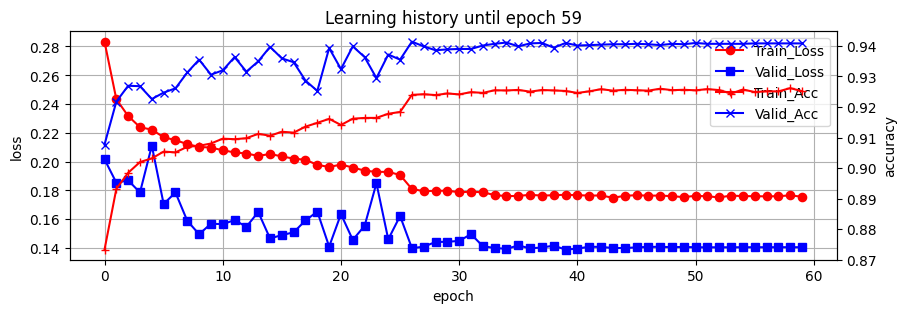

C:\Users\user\AppData\Local\Temp\ipykernel_9980\1068584868.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{pt_path}\\best_detect_GRU

Epoch: 60/150 | T_Loss 0.176 | T_Acc 0.925 | V_Loss  0.14 | V_Acc 0.941 | Time 3.843
Epoch: 59/150 | T_Loss 0.176 | T_Acc 0.926 | V_Loss  0.14 | V_Acc 0.941 | Time 3.869
Epoch: 58/150 | T_Loss 0.176 | T_Acc 0.925 | V_Loss  0.14 | V_Acc 0.941 | Time 3.916
Epoch: 57/150 | T_Loss 0.176 | T_Acc 0.925 | V_Loss  0.14 | V_Acc 0.941 | Time 3.717
Epoch: 56/150 | T_Loss 0.176 | T_Acc 0.925 | V_Loss  0.14 | V_Acc 0.941 | Time 3.752
Epoch: 55/150 | T_Loss 0.176 | T_Acc 0.926 | V_Loss  0.14 | V_Acc 0.941 | Time  3.64
Epoch: 54/150 | T_Loss 0.176 | T_Acc 0.924 | V_Loss  0.14 | V_Acc 0.941 | Time 3.908
Epoch: 53/150 | T_Loss 0.175 | T_Acc 0.926 | V_Loss  0.14 | V_Acc 0.941 | Time 3.828
Epoch: 52/150 | T_Loss 0.176 | T_Acc 0.926 | V_Loss  0.14 | V_Acc 0.941 | Time 3.719
Epoch: 51/150 | T_Loss 0.176 | T_Acc 0.925 | V_Loss  0.14 | V_Acc 0.941 | Time 3.692
Epoch: 50/150 | T_Loss 0.175 | T_Acc 0.926 | V_Loss 0.141 | V_Acc 0.941 | Time 3.668
Epoch: 49/150 | T_Loss 0.176 | T_Acc 0.926 | V_Loss 0.141 | V_Acc

In [105]:
if __name__ == "__main__":
    main()